In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/HURJC-main_drive.zip"

In [1]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os, warnings
from matplotlib import gridspec
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data = pd.read_excel('/content/HURJC-main_drive/calcific_tendinopathy_ddbb.xlsx')

In [3]:
data.head(30)

,image,calcium,pat_id,type,localization
0,0072879_001.png,1,72879,2,supraespinoso
1,0072879_002.png,1,72879,2,supraespinoso
2,00326955M_001.png,1,326955M,3,supraespinoso
3,00326955M_002.png,1,326955M,3,supraespinoso
4,0094847_001.png,0,94847,-1,NaN
5,00486523M_001.png,1,486523M,2,infraespinoso
6,00486523M_002.png,1,486523M,2,infraespinoso
7,00564810_001.png,1,564810,1,supraespinoso
8,00564810_002.png,1,564810,1,supraespinoso
9,00782404_001.png,1,782404,1,supraespinoso


In [4]:
'''train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.4,
    rotation_range = 15,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=0.2,
    
)
'''
train_datagen=ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization= True,
    rotation_range = 15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest",
    cval=0.0,
    rescale = 0.2)

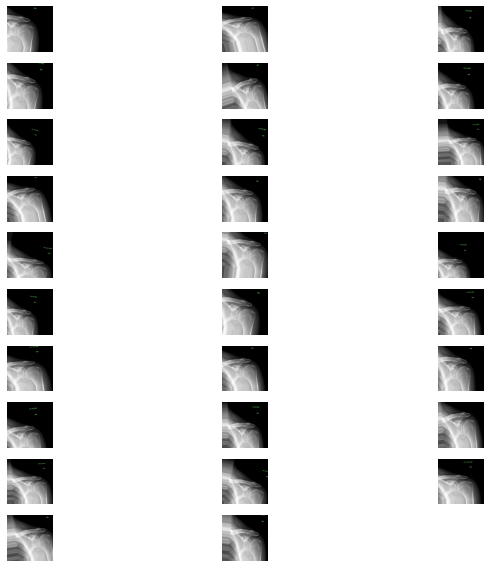

In [5]:
# let's plot some of the figures

from tensorflow.keras.preprocessing import image

fnames = [os.path.join('/content/HURJC-main_drive/train/class_1',fname) for fname in os.listdir('/content/HURJC-main_drive/train/class_1')]


img_path = fnames[1]

#reads image

img = image.load_img(img_path,target_size = (250,250))

x = image.img_to_array(img)

x = x.reshape((1,) + x.shape)

i = 1

plt.figure(figsize = (10,8))

for batch in train_datagen.flow(x,batch_size = 10):
    plt.subplot(10,3,i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    plt.axis('off')
    i += 1
    if i % 30 == 0:
        break
    
plt.tight_layout()

In [6]:
validation_datagen = ImageDataGenerator(rescale = 1.0/255.)
#test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [7]:
batch_size = 15
train_generator = train_datagen.flow_from_directory(
        '/content/HURJC-main_drive/train',
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(
        '/content/HURJC-main_drive/valid',
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode='binary')
#test_generator = test_datagen.flow_from_directory(
        #'/content/HURJC-main_drive/valid',
        #target_size=(150, 150),
        #batch_size=batch_size,
        #class_mode='binary')

Found 77 images belonging to 2 classes.
Found 36 images belonging to 2 classes.


In [8]:
#load ChestXnet model
from tensorflow.keras.applications import DenseNet121
    
base_model = DenseNet121(weights=None,
                            include_top=False,
                            input_shape=(250,250,3), pooling="avg")

predictions = tf.keras.layers.Dense(14, activation='sigmoid', name='predictions')(base_model.output)
base_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
base_model.load_weights("/content/HURJC-main_drive/CheXNet_Keras_0.3.0_weights.h5")
base_model.layers.pop()

In [9]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 125, 125, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 125, 125, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [10]:
# remove last layer to create our top layers
from tensorflow.keras import Model
new_model = Model(base_model.inputs, base_model.layers[-2].output)
#freezing the weights
new_model.trainable = False

new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 125, 125, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 125, 125, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [11]:
#add two dense layers on top of the conv_base
model = models.Sequential() 
model.add(new_model)
model.add(layers.Dense(256, activation='relu',name = 'dense_layer')) 
model.add(layers.Dense(1, activation='sigmoid',name = 'output_layer'))
#x = layers.Dense(64, activation='relu',name = 'dense_layer')(new_model.output)
#output = layers.Dense(1,activation = "sigmoid",name = 'output_layer')(new_model.output)

#model = Model(new_model.inputs,output)


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 1024)              7037504   
_________________________________________________________________
dense_layer (Dense)          (None, 256)               262400    
_________________________________________________________________
output_layer (Dense)         (None, 1)                 257       
Total params: 7,300,161
Trainable params: 262,657
Non-trainable params: 7,037,504
_________________________________________________________________


In [12]:
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy']
)

In [13]:
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch =steps_per_epoch,
    epochs=50,
    validation_data = validation_generator,
    validation_steps = validation_steps
)

Epoch 1/50
5/5 [==============================] - 12s 971ms/step - loss: 0.6298 - binary_accuracy: 0.6564 - val_loss: 0.8645 - val_binary_accuracy: 0.7000
Epoch 2/50
5/5 [==============================] - 2s 383ms/step - loss: 0.5096 - binary_accuracy: 0.8242 - val_loss: 0.6611 - val_binary_accuracy: 0.6667
Epoch 3/50
5/5 [==============================] - 2s 407ms/step - loss: 0.5291 - binary_accuracy: 0.7844 - val_loss: 0.5752 - val_binary_accuracy: 0.7667
Epoch 4/50
5/5 [==============================] - 2s 378ms/step - loss: 0.5681 - binary_accuracy: 0.7559 - val_loss: 0.5813 - val_binary_accuracy: 0.7333
Epoch 5/50
5/5 [==============================] - 2s 453ms/step - loss: 0.6688 - binary_accuracy: 0.6559 - val_loss: 0.6316 - val_binary_accuracy: 0.7000
Epoch 6/50
5/5 [==============================] - 2s 406ms/step - loss: 0.5231 - binary_accuracy: 0.7733 - val_loss: 0.6291 - val_binary_accuracy: 0.7000
Epoch 7/50
5/5 [==============================] - 2s 383ms/step - loss: 0.5

In [14]:
test_lost, test_acc = model.evaluate(validation_generator)
print(test_acc)

3/3 [==============================] - 1s 356ms/step - loss: 0.5794 - binary_accuracy: 0.7222
0.7222222089767456


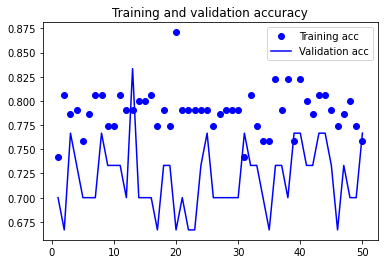

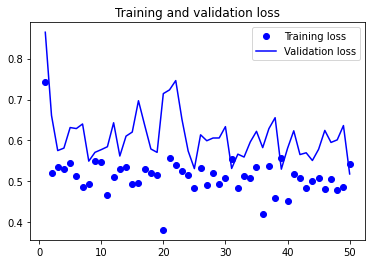

In [16]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [28]:
#FINE-TUNING

new_model.trainable = True
set_trainable = False
for layer in new_model.layers:
    if layer.name == 'conv5_block1_1_conv': 
        set_trainable = True
    if set_trainable: 
        layer.trainable = True
    else:
        layer.trainable = False

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 1024)              7037504   
_________________________________________________________________
dense_layer (Dense)          (None, 256)               262400    
_________________________________________________________________
output_layer (Dense)         (None, 1)                 257       
Total params: 7,300,161
Trainable params: 2,421,761
Non-trainable params: 4,878,400
_________________________________________________________________


In [30]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['binary_accuracy'])

In [31]:
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
history = model.fit( 
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
5/5 [==============================] - 10s 780ms/step - loss: 0.2241 - binary_accuracy: 0.8614 - val_loss: 1.2969 - val_binary_accuracy: 0.7333
Epoch 2/100
5/5 [==============================] - 2s 401ms/step - loss: 0.2289 - binary_accuracy: 0.8915 - val_loss: 1.0986 - val_binary_accuracy: 0.7333
Epoch 3/100
5/5 [==============================] - 2s 382ms/step - loss: 0.2140 - binary_accuracy: 0.8881 - val_loss: 1.1568 - val_binary_accuracy: 0.6667
Epoch 4/100
5/5 [==============================] - 2s 366ms/step - loss: 0.1130 - binary_accuracy: 0.9552 - val_loss: 0.9413 - val_binary_accuracy: 0.7333
Epoch 5/100
5/5 [==============================] - 2s 383ms/step - loss: 0.2501 - binary_accuracy: 0.8921 - val_loss: 0.8908 - val_binary_accuracy: 0.7333
Epoch 6/100
5/5 [==============================] - 2s 380ms/step - loss: 0.2869 - binary_accuracy: 0.8992 - val_loss: 0.9424 - val_binary_accuracy: 0.7000
Epoch 7/100
5/5 [==============================] - 2s 385ms/step - lo

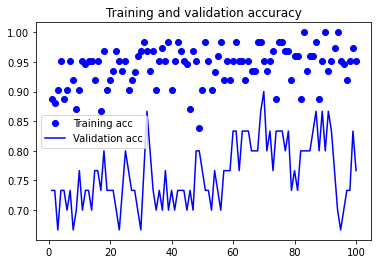

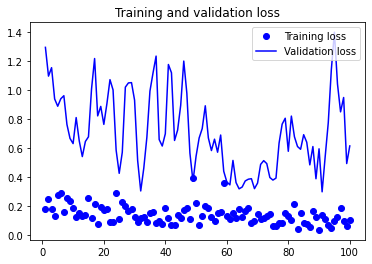

In [32]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

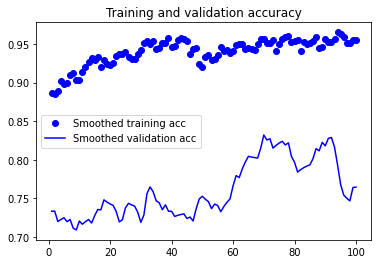

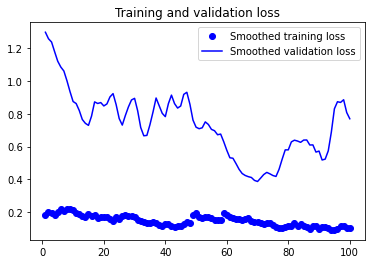

In [33]:
#Smooth the curve

def smooth_curve(points, factor=0.8): 
  smoothed_points = []
  for point in points:
      if smoothed_points:
          previous = smoothed_points[-1]
          smoothed_points.append(previous * factor + point * (1 - factor))
      else: 
          smoothed_points.append(point)
  return smoothed_points
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss') 
plt.legend()
plt.show()

In [34]:
test_lost, test_acc = model.evaluate(validation_generator)
print(test_acc)

3/3 [==============================] - 0s 93ms/step - loss: 0.5253 - binary_accuracy: 0.8056
0.8055555820465088
